# Temporal GraphML

In this notebook, we will introduce representative examples of the machine learning approaches for dealing with temporal graphs. We will offer a general understanding of their implementation using publicly available frameworks.

## Temporal Matrix Factorization

Temporal Matrix Factorization model (TMF) by Yu et al. (2017) is a method used for temporal link prediction, particularly in dynamic network scenarios. This technique leverages matrix factorization with temporal dynamics to model the evolution of links in a dynamic network over time.

We adopt the implementation provided in the publicly available library [OpenTLP](https://github.com/KuroginQin/OpenTLP). It integrates an encoder-decoder architecture, where the encoder learns model parameters through matrix factorization, and the decoder generates predictions based on these parameters.

In [ ]:
# Donwload the OpenTLP repository
!git clone https://github.com/KuroginQin/OpenTLP.git

Cloning into 'OpenTLP'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 147 (delta 0), reused 0 (delta 0), pack-reused 146 (from 1)
Receiving objects: 100% (147/147), 13.13 MiB | 25.61 MiB/s, done.
Resolving deltas: 100% (68/68), done.


OpenTLP contains a set of useful temporal graph data. Let's unzip it as follows:

In [ ]:
# Unzip the sample graph
%cd /content/OpenTLP/Python
!cd data && unzip data.zip

/content/OpenTLP/Python
Archive:  data.zip
  inflating: NetworkGAN_TMF_feats_Mesh-1.npy  
  inflating: Enron_edge_seq.npy      
  inflating: Mesh-1_edge_seq.npy     
  inflating: Mesh-1_feat.npy         
  inflating: Mesh-2_edge_seq.npy     
  inflating: Mesh-2_feat.npy         


For the TMF example, the Enron dataset is used as a case study.
The dataset consists of temporal snapshots of a graph with 184 nodes over 26 time points. Historical edge sequences (`edge_seq`) are loaded, representing graph snapshots at different timestamps.

Let's now implementing the TMF example. This code is adapted from the [OpenTLP examples](https://github.com/KuroginQin/OpenTLP/blob/main/Python/TMF_demo1.py).

### 1. Model Setup
- TMF is implemented with the following parameters:
  - **Latent dimensionality of node embeddings** (`hid_dim = 64`).
  - **Regularization coefficients** for model optimization (`alpha`, `beta`, and `theta`).
  - **Learning rate** for gradient-based optimization.
  - A **sliding window of historical snapshots** (`win_size = 5`) is used to predict the adjacency structure at the next time step.

### 2. Training the TMF Model
- For each time step after the historical window (`win_size` to `num_snaps`):
  - The model uses the last `win_size` adjacency matrices to learn a low-dimensional representation of the graph.
  - The learned representation is used to predict the adjacency matrix for the current time step.
- The adjacency matrices are refined to ensure symmetry and zero diagonal elements.

### 3. Evaluation
- The **Area Under the Curve (AUC)** score is computed to evaluate the quality of predictions against the ground truth adjacency matrix at each time step.
- The average AUC and standard deviation across all time steps are reported as metrics of model performance.

## Results
The model iteratively predicts the graph structure for each snapshot and computes the corresponding AUC. This provides insight into the TMF's ability to generalize and learn temporal patterns from historical graph data.

In [ ]:
# Import necessary libraries and modules
import numpy as np
import torch
from TMF.TMF import TMF  # Custom TMF implementation
from utils import get_adj_un, get_AUC  # Utility functions for adjacency and evaluation

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ====================
# Dataset and model configuration
data_name = 'Enron'  # Name of the dataset
num_nodes = 184  # Total number of nodes in the graph
num_snaps = 26  # Total number of snapshots (time points)
hid_dim = 64  # Dimensionality of the latent space
theta = 0.1  # Regularization parameter for model training
alpha = 0.01  # TMF-specific hyperparameter
beta = 0.01  # TMF-specific hyperparameter

# Load edge sequences from dataset
edge_seq = np.load(f'data/{data_name}_edge_seq.npy', allow_pickle=True)

# ====================
# Training hyperparameters
learn_rate = 1e-3  # Learning rate for the optimizer
win_size = 5  # Size of the historical window for snapshots
num_epochs = 200  # Number of training epochs

# ====================
# Initialize a list to store AUC scores for each snapshot
AUC_list = []

# Iterate through snapshots, starting after the initial window size
for tau in range(win_size, num_snaps):
    # Ground truth edges for the current snapshot
    edges = edge_seq[tau]
    gnd = get_adj_un(edges, num_nodes)  # Generate ground truth adjacency matrix

    # Collect adjacency matrices for historical snapshots within the window
    adj_list = []
    for t in range(tau - win_size, tau):
        edges = edge_seq[t]
        adj = get_adj_un(edges, num_nodes)
        adj_tnr = torch.FloatTensor(adj).to(device)
        adj_list.append(adj_tnr)

    # Initialize and train the TMF model
    TMF_model = TMF(num_nodes,
                    hid_dim,
                    win_size,
                    num_epochs,
                    alpha,
                    beta,
                    theta,
                    learn_rate,
                    device)

    adj_est = TMF_model.TMF_fun(adj_list)  # Predict adjacency matrix for the current snapshot

    # Convert predicted adjacency matrix to NumPy array if necessary
    adj_est = adj_est.cpu().data.numpy() if torch.cuda.is_available() else adj_est.data.numpy()

    # Refine the predicted adjacency matrix
    adj_est = (adj_est + adj_est.T) / 2  # Ensure symmetry
    np.fill_diagonal(adj_est, 0)  # Set diagonal elements to 0 (no self-loops)

    # Evaluate prediction quality using AUC metric
    AUC = get_AUC(adj_est, gnd, num_nodes)
    AUC_list.append(AUC)
    print(f'Snapshot {tau}: AUC = {AUC:.6f}')

# ====================
# Compute mean and standard deviation of AUC scores
AUC_mean = np.mean(AUC_list)
AUC_std = np.std(AUC_list, ddof=1)

# Display overall results
print(f'Mean AUC: {AUC_mean:.6f}')
print(f'Standard Deviation of AUC: {AUC_std:.6f}')

Snapshot 5: AUC = 0.763934
Snapshot 6: AUC = 0.827365
Snapshot 7: AUC = 0.761033
Snapshot 8: AUC = 0.852864
Snapshot 9: AUC = 0.866734
Snapshot 10: AUC = 0.855208
Snapshot 11: AUC = 0.870010
Snapshot 12: AUC = 0.827272
Snapshot 13: AUC = 0.846048
Snapshot 14: AUC = 0.851209
Snapshot 15: AUC = 0.874804
Snapshot 16: AUC = 0.771274
Snapshot 17: AUC = 0.803593
Snapshot 18: AUC = 0.780443
Snapshot 19: AUC = 0.775633
Snapshot 20: AUC = 0.816954
Snapshot 21: AUC = 0.794130
Snapshot 22: AUC = 0.852839
Snapshot 23: AUC = 0.940696
Snapshot 24: AUC = 0.851152
Snapshot 25: AUC = 0.838655
Mean AUC: 0.829612
Standard Deviation of AUC: 0.044871


## Temporal Random Walk
We pesent here a Temporal Random Walk-based method called CTDNE, by Nguyen et al. (2018), for learning time-preserving embedding.

This code is adapted from [StellarGraph](https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/ctdne-link-prediction.ipynb#scrollTo=I2Vw-NfmeMU5).

In [ ]:
%%capture
# install StellarGraph from this modified repo if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  !pip install git+https://github.com/VenkateshwaranB/stellargraph.git

In this example we will be using again the Enron dataset. You can find a specific class handling the Enron dataset in StellarGraph.

In [23]:
from stellargraph.datasets import IAEnronEmployees

dataset = IAEnronEmployees()
print(dataset.description)
full_graph, edges = dataset.load()

A dataset of edges that represent emails sent from one employee to another.There are 50572 edges, and each of them contains timestamp information. Edges refer to 151 unique node IDs in total.Ryan A. Rossi and Nesreen K. Ahmed “The Network Data Repository with Interactive Graph Analytics and Visualization” (2015)


In this example, we show how random walks can be obtained from time graphs, and how they can be used to generate network embeddings for a link prediction task.

Since we will be address a link prediction task, let's prepare the graph for the task: Let's split the edges into two parts:

* the oldest edges are used to create the graph structure
* the recent edges are what we are interested in predicting - we randomly split this part further into training and test sets.

In [24]:
import pandas as pd
from stellargraph import StellarGraph

# Finally, let's create an instance of the StellarGraph class
graph = StellarGraph(
    nodes=pd.DataFrame(index=full_graph.nodes()),
    edges=edges,
    edge_weight_column="time",
)

It's now time for running the Temporal Random Walk algorithm

In [25]:
from stellargraph.data import TemporalRandomWalk
from gensim.models import Word2Vec

num_walks_per_node = 10
walk_length = 80
context_window_size = 10

num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)

temporal_rw = TemporalRandomWalk(graph)
temporal_walks = temporal_rw.run(
    num_cw=num_cw,
    cw_size=context_window_size,
    max_walk_length=walk_length,
    walk_bias="exponential",
)

print("Number of temporal random walks: {}".format(len(temporal_walks)))

Number of temporal random walks: 1721


In [26]:
embedding_size = 128
temporal_model = Word2Vec(
    temporal_walks,
    vector_size=embedding_size, # "size" in older gensim versions
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    epochs=1, # "iter" in older gensim versions
)

Let's visualize the embeddings:

<ipython-input-27-05efd49180cd>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(x_t[:, 0], x_t[:, 1], c=y, cmap="jet", alpha=alpha)


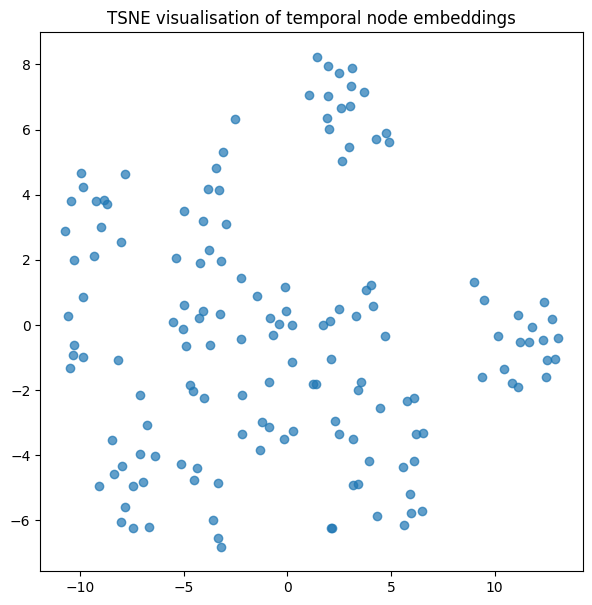

In [27]:
import numpy as np
np.random.seed(5)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

def plot_tsne(title, x, y=None):
    tsne = TSNE(n_components=2)
    x_t = tsne.fit_transform(x)

    plt.figure(figsize=(7, 7))
    plt.title(title)
    alpha = 0.7 if y is None else 0.5

    scatter = plt.scatter(x_t[:, 0], x_t[:, 1], c=y, cmap="jet", alpha=alpha)
    if y is not None:
        plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")

temporal_node_embeddings = temporal_model.wv.vectors
plot_tsne("TSNE visualisation of temporal node embeddings", temporal_node_embeddings);

You may want to use these embeddings for downstream tasks such as link prediction! To this aim, you can split the dataset in order to create "future" link examples. Check [the stellargraph repo](https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/ctdne-link-prediction.ipynb#scrollTo=I2Vw-NfmeMU5) for a full example

## Temporal Graph Neural Network
In this example, we will explore the implementation of Temporal Graph Networks (TGN) using PyTorch Geometric (PyG). TGNs are designed to handle dynamic graphs where interactions between nodes occur at different timestamps. We'll use the Wikipedia dataset from JODIE, where nodes represent users and articles, and edges represent user-article interactions.

In [ ]:
%%capture
# install PyTorch Geometric if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  import torch

  def format_pytorch_version(version):
    return version.split('+')[0]

  TORCH_version = torch.__version__
  TORCH = format_pytorch_version(TORCH_version)

  def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

  CUDA_version = torch.version.cuda
  CUDA = format_cuda_version(CUDA_version)

  !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
  !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
  !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
  !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
  !pip install torch-geometric

First, let's set up our environment and load the data.
We use the JODIE Wikipedia dataset, which contains temporal interactions between users and articles.

The `TemporalDataLoader` is specially designed for temporal graphs. The `neg_sampling_ratio=1.0` means for each positive edge, we sample one negative edge for training.

In [33]:
# Setup and Data Loading
import os.path as osp
import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear
from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Wikipedia dataset from JODIE
path = osp.join('data', 'JODIE')
dataset = JODIEDataset(path, name='wikipedia')
data = dataset[0]
data = data.to(device)  # Move data to GPU if available

# Split dataset into train, validation, and test sets
train_data, val_data, test_data = data.train_val_test_split(
    val_ratio=0.15, test_ratio=0.15)

# Create data loaders with negative sampling
train_loader = TemporalDataLoader(
    train_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)

val_loader = TemporalDataLoader(
    val_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)

test_loader = TemporalDataLoader(
    test_data,
    batch_size=200,
    neg_sampling_ratio=1.0,
)

neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)

Let's now proceed implementing the key components of TGN.
* The memory module is a key component of TGN that maintains node states over time

In [35]:
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

memory_dim = 100
time_dim = 100
embedding_dim = 100

memory = TGNMemory(
    data.num_nodes,           # Number of nodes in the graph
    data.msg.size(-1),        # Message dimension
    memory_dim,               # Memory dimension
    time_dim,                 # Time encoding dimension
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

* Together with the `TGNMemory`, we will also create a GNN for obtaining the embeddings. In this example, we will define a `GraphAttentionEmbedding` class, which uses the `TransformerConv` module (a message passing module implemented in PyTorch).

In [36]:
class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2,
                                  dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        # Compute relative temporal encoding
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        # Concatenate temporal and message features
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)

# Create the GNN
gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)

The GraphAttentionEmbedding uses a transformer-based graph convolution that:
1. Encodes temporal information using relative timestamps
2. Combines temporal encodings with edge messages
3. Applies multi-head attention to compute node embeddings

* Finally, let's use a simple MLP that predicts link probabilities between node pairs:

In [37]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)

# Create the LinkPredictor Object
link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

### Training
A few important points about the training:

1. Memory and neighbor states are reset at the start of each epoch
For each batch, we first compute temporal neighborhoods using neighbor_loader
2. Node embeddings are computed using the current memory state and graph attention
3. The model predicts both positive and negative links
After prediction, we update the memory with the true interactions


In [ ]:
# Let's define the optimizer and the Loss function
optimizer = torch.optim.Adam(set(memory.parameters()) | set(gnn.parameters()) | set(link_pred.parameters()), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

# Helper vector to map global node indices to local ones.
assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)

In [38]:
def train():
    # Reset memory and neighbor loader states
    memory.reset_state()
    neighbor_loader.reset_state()

    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        # Get temporal neighborhood
        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        # Compute node embeddings
        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))

        # Predict positive and negative links
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        # Compute binary cross entropy loss
        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))

        # Update memory and graph structure
        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events

Let's also implement a testing function for model evaluation

In [39]:
@torch.no_grad()
def test(loader):
    # Set all modules to evaluation mode
    memory.eval()
    gnn.eval()
    link_pred.eval()

    # Set random seed for reproducible negative sampling
    torch.manual_seed(12345)

    aps, aucs = [], []
    for batch in loader:
        batch = batch.to(device)

        # Get temporal neighborhood for current batch
        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        # Create mapping from global to local node indices
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        # Get node embeddings from memory
        z, last_update = memory(n_id)
        # Update embeddings using graph attention
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))

        # Predict on positive and negative edges
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        # Combine predictions and convert to probabilities
        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        # Create ground truth labels (1 for positive edges, 0 for negative)
        y_true = torch.cat(
            [torch.ones(pos_out.size(0)),
             torch.zeros(neg_out.size(0))], dim=0)

        # Calculate metrics
        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))

        # Update memory and graph with ground truth interactions
        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

    # Return average metrics across all batches
    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())

We evaluate the model using two metrics:

* Average Precision Score (AP): Measures the precision-recall trade-off
* Area Under ROC Curve (AUC): Measures the model's ability to distinguish between classes

Finally, let's train and test the model

In [40]:
# Training and evaluation loop
for epoch in range(1, 51):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

    # Evaluate on validation and test sets
    val_ap, val_auc = test(val_loader)
    test_ap, test_auc = test(test_loader)

    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

Epoch: 01, Loss: 1.1953
Val AP: 0.8400, Val AUC: 0.8394
Test AP: 0.8249, Test AUC: 0.8217
Epoch: 02, Loss: 0.9529
Val AP: 0.8881, Val AUC: 0.8773
Test AP: 0.8728, Test AUC: 0.8625
Epoch: 03, Loss: 0.8445
Val AP: 0.9094, Val AUC: 0.8986
Test AP: 0.8955, Test AUC: 0.8858
Epoch: 04, Loss: 0.7768
Val AP: 0.9191, Val AUC: 0.9075
Test AP: 0.9053, Test AUC: 0.8954
Epoch: 05, Loss: 0.7427
Val AP: 0.9231, Val AUC: 0.9117
Test AP: 0.9088, Test AUC: 0.8997
Epoch: 06, Loss: 0.7220
Val AP: 0.9260, Val AUC: 0.9147
Test AP: 0.9105, Test AUC: 0.9024
Epoch: 07, Loss: 0.7063
Val AP: 0.9271, Val AUC: 0.9164
Test AP: 0.9128, Test AUC: 0.9051
Epoch: 08, Loss: 0.6925
Val AP: 0.9285, Val AUC: 0.9180
Test AP: 0.9145, Test AUC: 0.9074
Epoch: 09, Loss: 0.6801
Val AP: 0.9306, Val AUC: 0.9204
Test AP: 0.9177, Test AUC: 0.9096
Epoch: 10, Loss: 0.6675
Val AP: 0.9318, Val AUC: 0.9220
Test AP: 0.9199, Test AUC: 0.9117
Epoch: 11, Loss: 0.6555
Val AP: 0.9335, Val AUC: 0.9237
Test AP: 0.9224, Test AUC: 0.9142
Epoch: 12,

The model achieves around 93.50% performance on the Wikipedia dataset. Notice that the performance differs slightly from the original TGN paper as noted in the PyTorch Geometric repository.

Here, a slightly different evaluation setup is used. Predictions within the same batch are made in parallel, meaning that interactions occurring later in the batch do not have access to any information about earlier interactions in the same batch. By contrast, the original TGN paper's code allows access to earlier interactions in the batch when sampling node neighborhoods for later interactions. While both methods are valid, we, in collaboration with the authors of the paper, chose to present this version as it is more realistic and provides a better testing ground for future methodologies.

### Final notes
* The interested reader can take a look at [Pytorch Geometric Temporal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html) a temporal graph neural network extension library for PyTorch Geometric.
* A DGL implementation of TGN can be found [here](https://github.com/ytchx1999/TGN-DGL)